# Experiment 3

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
rcParams['pdf.fonttype']=42

from vgc_project.r import create_R_model_interface, ImmutableDataFrame
from vgc_project.parameter_fit import create_fit_vgc_model_to_trials, Trial

joblib_cache_location = "./_analysiscache"
rmods = create_R_model_interface(joblib_cache_location=joblib_cache_location)
fit_vgc_model_to_trials = create_fit_vgc_model_to_trials(joblib_cache_location=joblib_cache_location)

import analysisutils
from analysisutils import predictor_names, short_predictor_names
from prep_data import \
    mazes,\
    model_preds,\
    get_exp3_at__exp3_mt,\
    get_exp5b_at__exp5b_mt,\
    get_exp6b_at__exp6b_mt

exp3_at, exp3_mt = get_exp3_at__exp3_mt()

R[write to console]: Loading required package: Matrix



In [2]:
exp3_at_im = ImmutableDataFrame(exp3_at)
exp3_mt_im = ImmutableDataFrame(exp3_mt)

In [3]:
exp3_acc_vgc_sum = analysisutils.single_predictor_analysis(
    name='Exp. 3 VGC accuracy model',
    data=exp3_mt_im,
    dv='correct',
    model_func='glmer',
    random_effects='(1 | sessionId)',
    predictor='vgc_weight_Z',
    rmods=rmods,
    coeff_digits=3,
    normalized_predictor=True
)
exp3_conf_vgc_sum = analysisutils.single_predictor_analysis(
    name='Exp. 3 VGC confidence model',
    data=exp3_mt_im,
    dv='conf_N',
    model_func='lmer',
    random_effects='(1 | sessionId) + (1 | grid)',
    predictor='vgc_weight_Z',
    rmods=rmods,
    coeff_digits=3,
    normalized_predictor=True
)
exp3_attn_vgc_sum = analysisutils.single_predictor_analysis(
    name='Exp. 3 VGC attention model',
    data=exp3_at_im,
    dv='attention_N',
    model_func='lmer',
    random_effects='(1 | sessionId) + (1 | grid)',
    predictor='vgc_weight_Z',
    rmods=rmods,
    coeff_digits=3,
    normalized_predictor=True
)

with open("./inputs/exp3_acc_vgc_single_summary.tex", "w") as f:
    f.write(exp3_acc_vgc_sum.summary)
with open("./inputs/exp3_conf_vgc_single_summary.tex", "w") as f:
    f.write(exp3_conf_vgc_sum.summary)
with open("./inputs/exp3_attn_vgc_single_summary.tex", "w") as f:
    f.write(exp3_attn_vgc_sum.summary)
print("VGC fit alone (Accuracy):", exp3_acc_vgc_sum.summary)
print("VGC fit alone (Confidence):", exp3_conf_vgc_sum.summary)
print("VGC fit alone (Awareness)", exp3_attn_vgc_sum.summary)

VGC fit alone (Accuracy): $\chi^2(1) = 249.34, p  < 1.0 \times 10^{-16}$; $\beta = 0.648$, S.E. $= 0.042$
VGC fit alone (Confidence): $\chi^2(1) = 432.76, p  < 1.0 \times 10^{-16}$; $\beta = 0.104$, S.E. $= 0.005$
VGC fit alone (Awareness) $\chi^2(1) = 837.47, p  < 1.0 \times 10^{-16}$; $\beta = 0.175$, S.E. $= 0.006$


## Critical obstacle analysis

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(lme4)
library(lmerTest)
library(lmtest)
library(scales)

Attaching package: ‘lmerTest’



    lmer



    step



Attaching package: ‘zoo’



    as.Date, as.Date.numeric




In [6]:
%%R -i exp3_mt,exp3_at -o acc_test,conf_test,attn_test
df <- exp3_mt[exp3_mt$obs_type %in% c('crit', 'irrel'),]
df$obs_type <- factor(df$obs_type, levels=c("irrel", "crit")) #irrelevant as baseline

acc_test <- lrtest(
    glmer(
        correct ~ 1 + (1 | sessionId),
        family=binomial('logit'),
        data=df
    ),
    glmer(
        correct ~ obs_type + (1 | sessionId),
        family=binomial('logit'),
        data=df
    )
)
conf_test <- lrtest(
    lmer(
        conf_N ~ 1 + (1 | sessionId),
        REML=F,
        data=df
    ),
    lmer(
        conf_N ~ obs_type + (1 | sessionId),
        REML=F,
        data=df
    )
)
df <- exp3_at[exp3_at$obs_type %in% c('crit', 'irrel'),]
df$obs_type <- factor(df$obs_type, levels=c("irrel", "crit")) #irrelevant as baseline

attn_test <- lrtest(
    lmer(
        attention_N ~ 1 + (1 | sessionId),
        REML=F,
        data=df
    ),
    lmer(
        attention_N ~ obs_type + (1 | sessionId),
        REML=F,
        data=df
    )
)

In [7]:
def crit_obs_string_summary(row):
    return f"$\chi^2({int(row['Df']):d}) = " + \
        f"{row['Chisq']:.2f}" + \
        ", p " + analysisutils.pval_to_string(row["Pr(>Chisq)"]) + "$"
with open("./inputs/exp3_critobs_acc_test.tex", "w") as f:
    summary_string = crit_obs_string_summary(acc_test.iloc[1])
    f.write(summary_string)
    print("acc:", summary_string)
with open("./inputs/exp3_critobs_conf_test.tex", "w") as f:
    summary_string = crit_obs_string_summary(conf_test.iloc[1])
    f.write(summary_string)
    print("conf:", summary_string)
with open("./inputs/exp3_critobs_attn_test.tex", "w") as f:
    summary_string = crit_obs_string_summary(attn_test.iloc[1])
    f.write(summary_string)
    print("attn:", summary_string)

acc: $\chi^2(1) = 37.02, p = 1.2 \times 10^{-9}$
conf: $\chi^2(1) = 53.57, p = 2.5 \times 10^{-13}$
attn: $\chi^2(1) = 45.39, p = 1.6 \times 10^{-11}$


# Figures

## Critical Maze example

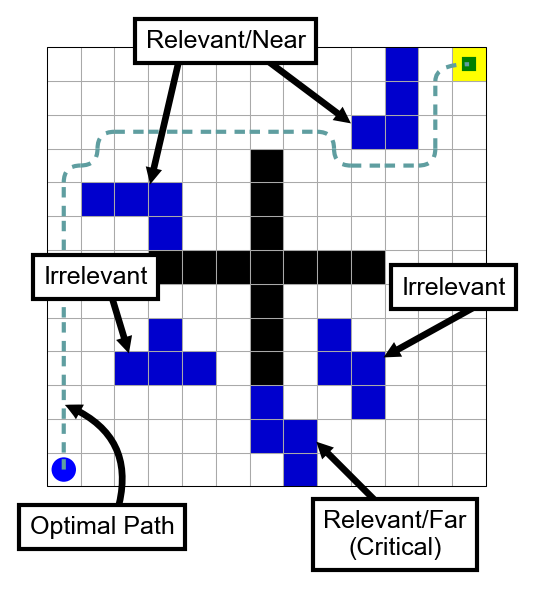

In [5]:
from matplotlib.patches import Circle, Rectangle
from msdm.algorithms import PolicyIteration
from msdm.domains import GridWorld
import random

# create figure
fig_width_mm = 50
fig_height_mm = 50
mm_to_inch = 1/25.4 
spinewidth = .5

assert fig_width_mm <= 182
assert fig_height_mm <= 245

fig, ax = plt.subplots(
    1, 1, 
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)

gw = GridWorld(
    mazes['grid-13'],
    wall_features="0123456#",
    absorbing_features="G",
    initial_features="S"
)
gwp = gw.plot(
    ax=ax,
    featurecolors={**{c: 'mediumblue' for c in '0123456'}, '#': 'k', 'G': 'yellow'},
    plot_initial_states=False,
    plot_absorbing_states=False,
    plot_walls=False,
)
for artist in gwp.ax.get_children():
    try:
        artist.set_linewidth(.25)
    except AttributeError:
        # print(artist)
        pass
gwp.ax.add_patch(Circle((.5, .5), .3, color='blue'))
gwp.ax.add_patch(Rectangle((12.35, 12.35), .3, .3, color='green'))

traj = PolicyIteration().plan_on(gw).policy.run_on(gw, rng=random.Random(1234)).state_traj
gwp.plot_trajectory(traj, lw=1.0, jitter_var=.001, linestyle=(0, (2.5, 2)), color='cadetblue')

# Annotation
textbox_kwargs = dict(
    font="Arial", fontsize=6, bbox=dict(fc='w', ec='k', linewidth=1.0, pad=2.5)
)
arrow_kwargs = dict(
    #textcoords='offset points',
    xycoords='data',
    size=8,
    # bbox=dict(boxstyle="round", fc="0.8"),
    arrowprops=dict(
        arrowstyle="simple",
        fc="k",
        ec="none",
        # patchB=el,
        connectionstyle="arc3,rad=0.5"
        # connectionstyle="angle,angleA=0,angleB=90,rad=10"
    )
)
gwp.ax.text(
    -.5, -1.4, "Optimal Path", **textbox_kwargs, zorder=2
)
gwp.ax.annotate(
    '',
    xy=(.3, 2.5),
    xytext=(2, -1), 
    zorder=1,
    **arrow_kwargs
)

gwp.ax.text(
    -.1, 6, "Irrelevant", **textbox_kwargs, zorder=2
)
gwp.ax.annotate(
    '',
    xy=(2.5, 3.7),
    xytext=(1.5, 7), 
    zorder=1,
    xycoords='data',
    size=8,
    arrowprops=dict(
        arrowstyle="simple",
        fc="k",
        ec="none",
    )
)

gwp.ax.text(
    10.5, 5.7, "Irrelevant", **textbox_kwargs, zorder=2
)
gwp.ax.annotate(
    '',
    xy=(9.75, 3.7),
    xytext=(13, 5.5), 
    zorder=1,
    xycoords='data',
    size=8,
    arrowprops=dict(
        arrowstyle="simple",
        fc="k",
        ec="none",
    )
)

gwp.ax.text(
    10.3, -2, "Relevant/Far\n(Critical)", **textbox_kwargs, zorder=2, ha='center'
)
gwp.ax.annotate(
    '',
    xy=(7.8, 1.5),
    xytext=(11.3, -2), 
    zorder=1,
    xycoords='data',
    size=8,
    arrowprops=dict(
        arrowstyle="simple",
        fc="k",
        ec="none",
    )
)

gwp.ax.text(
    5.3, 13, "Relevant/Near", **textbox_kwargs, zorder=2, ha='center'
)
gwp.ax.annotate(
    '',
    xy=(3, 8.7),
    xytext=(4., 13), 
    zorder=1,
    xycoords='data',
    size=8,
    arrowprops=dict(
        arrowstyle="simple",
        fc="k",
        ec="none",
    )
)
gwp.ax.annotate(
    '',
    xy=(9.2, 10.6),
    xytext=(6., 13), 
    zorder=1,
    xycoords='data',
    size=8,
    arrowprops=dict(
        arrowstyle="simple",
        fc="k",
        ec="none",
    )
)
# fig.savefig("results/crit_maze_example.svg")
fig.savefig("results/crit_maze_example.pdf")

## Exp 3, 5a, 6a Memory Accuracy Controls

In [6]:
from matplotlib.lines import Line2D

def bin_sem(v):
    return np.sqrt(np.mean(v)*(1-np.mean(v))/len(v))

def plot_by_obs_relevant_near(by_obs, model_preds, ax=None, figsize=(8, 8), dpi=150):
    by_obs = by_obs.merge(model_preds[['grid', 'obstacle', 'vgc_weight', 'optpolicy_dist']], on=['grid', 'obstacle'])
    by_obs['near'] = (by_obs['optpolicy_dist'] <= by_obs['optpolicy_dist'].median())
    by_obs['relevant'] = by_obs['vgc_weight'] >= .5
    by_obs['critical'] = ~by_obs['near'] & by_obs['relevant']
    by_obs['relevant_distance'] = by_obs.apply(
        lambda r: "irrelevant" if not r['relevant'] else (
            "relevant_near" if r['near'] else "relevant_far"
        ),
        axis=1
    )
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    ax.errorbar(x=by_obs['correct'], y=by_obs['conf_N'], 
                 xerr=by_obs['correct.sem'], 
                 yerr=by_obs['conf_N.sem'],
                 fmt='none',
                 ecolor='grey', 
                 zorder=-1,
                 capthick=.4,
                 capsize=1,
                 linewidth=.4
                )
    ax.plot([.5, .5], [.2, 1.0], color='silver', linestyle='--', zorder=-1, linewidth=.5)
    ax.plot([.2, 1.0], [.5, .5], color='silver', linestyle='--', zorder=-1, linewidth=.5)
    g = sns.scatterplot(
        data=by_obs, x="correct", y="conf_N", 
        style='relevant_distance', 
        hue="relevant", 
        # palette=['#3f7f93','#da3b46'], 
        palette=['#0AB300','#C10048'], 
        s=50,
        edgecolor='k', 
        linewidth=.4,
        ax=ax, 
        hue_order=[True, False],
        markers={"relevant_near": ".", "relevant_far": 'P', 'irrelevant': 'X'},
    )
    
    # axes
    spinewidth = .5
    for spine in ['top','bottom','left','right']:
        ax.spines[spine].set_linewidth(spinewidth)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # ax.set_ylim(.282, .9)
    # ax.set_xlim(.382, 1.0)
    ax.set_ylim(.282 - .05, .9)
    ax.set_xlim(.382 - .05, 1.0)
    
    d = 1.0  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
                  linestyle="none", color='k', mec='k', mew=spinewidth, clip_on=False)
    ax.plot([0], [.05], transform=ax.transAxes, **{**kwargs, 'color': 'green', 'mec': 'w', 'mew': spinewidth*5}, zorder=10)
    ax.plot([0], [.04], transform=ax.transAxes, **kwargs, zorder=11)
    ax.plot([0], [.06], transform=ax.transAxes, **kwargs, zorder=11)
    ax.plot([.05 - .0], [0], transform=ax.transAxes, **{**kwargs, 'color': 'green', 'mec': 'w', 'mew': spinewidth*4}, zorder=10)
    ax.plot([.04 - .0 - .000], [0], transform=ax.transAxes, **kwargs, zorder=11)
    ax.plot([.06 - .0 + .000], [0], transform=ax.transAxes, **kwargs, zorder=11)
    
    g.set_xlabel("Accuracy", fontsize=6, fontname="Arial")
    g.set_ylabel("Confidence", fontsize=6, fontname="Arial")
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = 5, width=.4, length=2, pad=1)
    xticks = [ax.get_xlim()[0], .4, .5, .6, .7, .8, .9, 1.0]
    yticks = [ax.get_ylim()[0], .3, .4, .5, .6, .7, .8, .9]
    g.set_xticks(xticks)
    g.set_yticks(yticks)
    g.set_xticklabels(['0.0']+xticks[1:], fontname="Arial")
    g.set_yticklabels(['0.0']+yticks[1:], fontname="Arial")
    # g.set_yticklabels(g.get_yticks(), size = 7, fontname="Arial")
    # g.set_xticklabels(g.get_xticks(), size = 7, fontname="Arial")
    g.legend_.remove()
    ax.set_aspect(1)
    
    return g

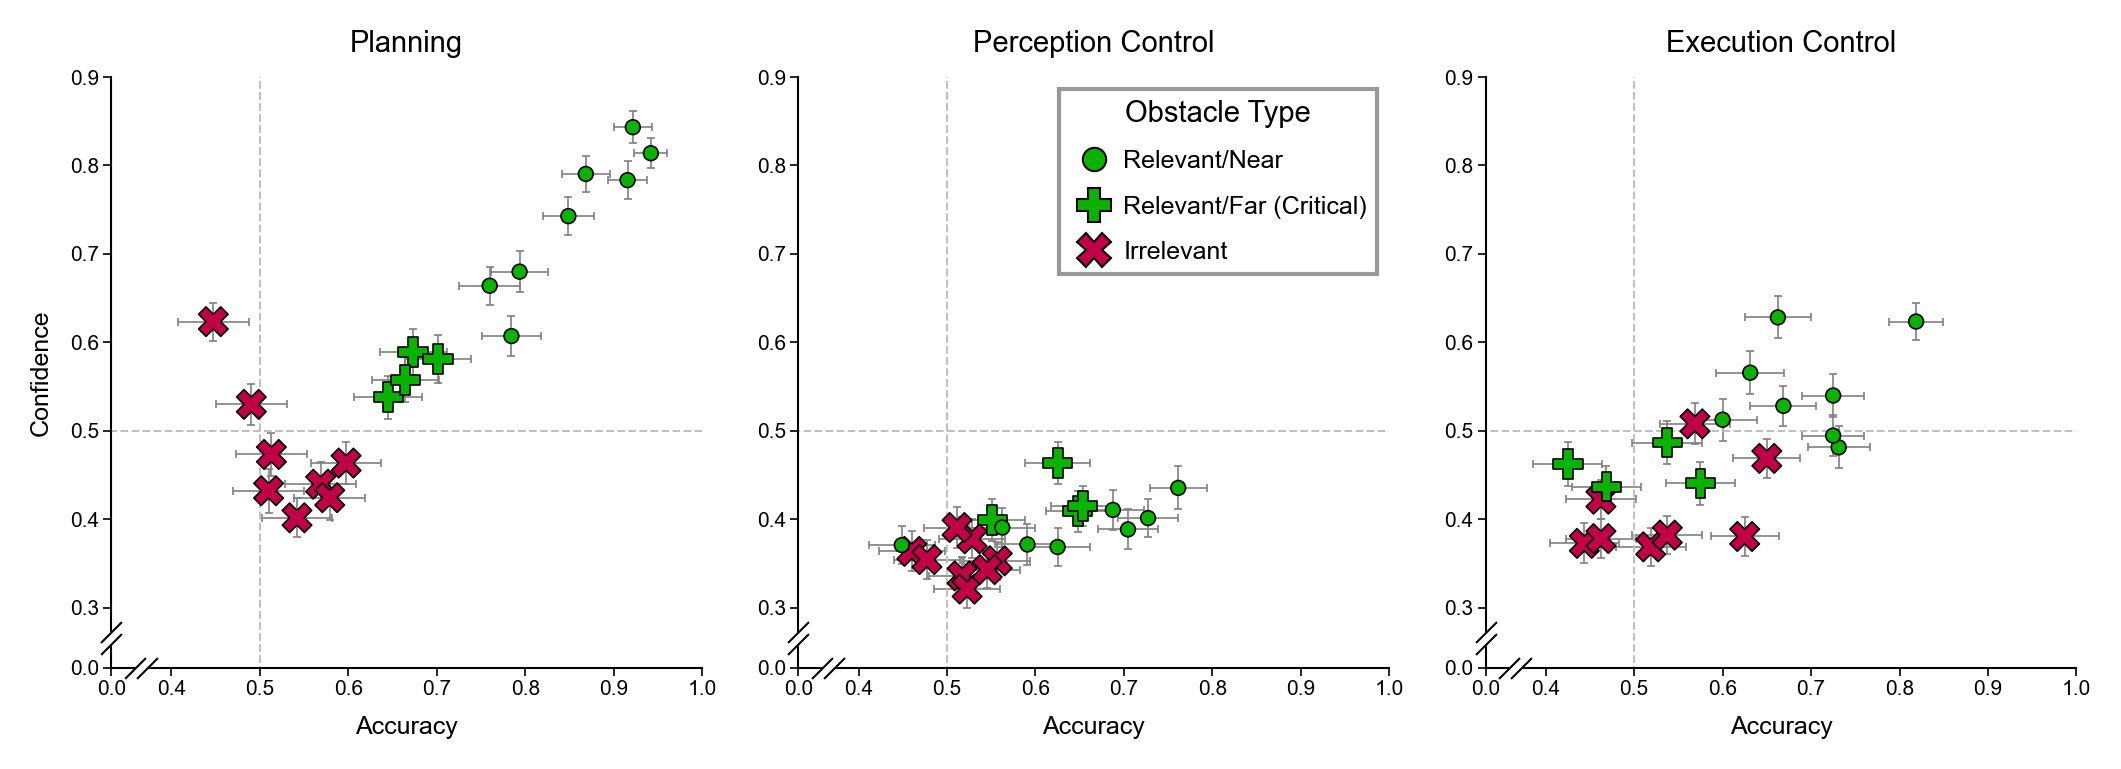

In [7]:
_, exp5b_mt = get_exp5b_at__exp5b_mt()
_, exp6b_mt = get_exp6b_at__exp6b_mt()

# create figure
fig_width_mm = 180
fig_height_mm = 60
mm_to_inch = 1/25.4 
spinewidth = .5

assert fig_width_mm <= 182
assert fig_height_mm <= 245

fig, axes = plt.subplots(
    1, 3, 
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
# fig, axes = plt.subplots(1, 3, figsize=(7.5*3, 8), dpi=150)
axes = list(axes.flatten())
exp3_by_obs = pd.concat([
    exp3_mt.groupby(['grid', 'obstacle'])[['correct', 'conf_N']].mean(),
    exp3_mt.groupby(['grid', 'obstacle'])['correct'].agg(bin_sem).rename('correct.sem'),
    exp3_mt.groupby(['grid', 'obstacle'])['conf_N'].sem().rename('conf_N.sem'),
], axis=1)
g = plot_by_obs_relevant_near(exp3_by_obs, model_preds=model_preds, ax=axes.pop(0))
g.set_xlabel("Accuracy")
g.set_title("Planning", fontsize=7, fontname="Arial")

exp5b_by_obs = pd.concat([
    exp5b_mt.groupby(['grid', 'obstacle'])[['correct', 'conf_N']].mean(),
    exp5b_mt.groupby(['grid', 'obstacle'])['correct'].agg(bin_sem).rename('correct.sem'),
    exp5b_mt.groupby(['grid', 'obstacle'])['conf_N'].sem().rename('conf_N.sem'),
], axis=1)
g = plot_by_obs_relevant_near(exp5b_by_obs, model_preds=model_preds, ax=axes.pop(0))
g.set_ylabel("")
# \nOnly Perception (Exp. 5b)
g.set_xlabel("Accuracy")
g.set_ylabel("")
g.set_title("Perception Control", fontsize=7, fontname="Arial")

import matplotlib.font_manager as font_manager

legend_elements = [
    Line2D([0], [0], marker='.', color='#0AB300', label='Relevant/Near', markersize=14*.8, lw=0, mew=.5, mec='k'),
    Line2D([0], [0], marker='P', color='#0AB300', label='Relevant/Far (Critical)', markersize=10*.8, lw=0, mew=.5, mec='k'),
    Line2D([0], [0], marker='X', color='#C10048', label='Irrelevant', markersize=10*.8, lw=0, mew=.5, mec='k'),
]
legend = g.legend(
    handles=legend_elements,
    loc='upper right',
    prop=font_manager.FontProperties(family='Arial', style='normal', size=6),
    handletextpad=.16,
    title="Obstacle Type",
    labelspacing=.9,
    fancybox=False,
    edgecolor='grey',
    facecolor='w'
    # title_fontproperties=font_manager.FontProperties(family='Arial', style='normal', size=7),
)
legend_title = legend.get_title()
legend_title.set_fontproperties("Arial")
legend_title.set_fontsize(7)
# legend._legend_box.align = "left"


exp6b_by_obs = pd.concat([
    exp6b_mt.groupby(['grid', 'obstacle'])[['correct', 'conf_N']].mean(),
    exp6b_mt.groupby(['grid', 'obstacle'])['correct'].agg(bin_sem).rename('correct.sem'),
    exp6b_mt.groupby(['grid', 'obstacle'])['conf_N'].sem().rename('conf_N.sem'),
], axis=1)
g = plot_by_obs_relevant_near(exp6b_by_obs, model_preds=model_preds, ax=axes.pop(0))
g.set_ylabel("")
# \nOnly Execution (Exp. 6b)
g.set_xlabel("Accuracy")
g.set_title("Execution Control", fontsize=7, fontname="Arial")

plt.tight_layout(pad=.6)
# fig.savefig("./results/crit_mazes_and_controls.svg")
fig.savefig("./results/crit_mazes_and_controls.pdf")

In [8]:
# check correlation between conf and accuracy for irrlevant obs
import scipy
by_obs = exp3_by_obs.merge(model_preds[['grid', 'obstacle', 'vgc_weight', 'optpolicy_dist']], on=['grid', 'obstacle'])
by_obs['near'] = (by_obs['optpolicy_dist'] <= by_obs['optpolicy_dist'].median())
by_obs['relevant'] = by_obs['vgc_weight'] >= .5
by_obs['critical'] = ~by_obs['near'] & by_obs['relevant']
by_obs['relevant_distance'] = by_obs.apply(
    lambda r: "irrelevant" if not r['relevant'] else (
        "relevant_near" if r['near'] else "relevant_far"
    ),
    axis=1
)
irr_by_obs = by_obs[by_obs['relevant_distance'] == 'irrelevant']
rstat, pval = scipy.stats.pearsonr(irr_by_obs['conf_N'], irr_by_obs['correct'])
f"$r({len(irr_by_obs) - 2}) = {rstat:.2f}, p = {pval:.2f}$"

'$r(6) = -0.75, p = 0.03$'

## Lesioning Analysis plot

In [9]:
exp3_lesion_correct_res = analysisutils.global_lesion_analysis(
    name="Exp. 3 Accuracy",
    data=exp3_mt_im,
    dv="correct",
    model_func="glmer",
    random_effects="(1 | sessionId)",
    predictors=[
        'vgc_weight_Z',
        'log_traj_based_hitcount_Z',
        'graph_based_hitcount_Z',
        'bottleneck_dist_Z',
        'sr_occ_Z',
        'nav_mindist_Z',
        'nav_mindist_timestep_Z',
        # 'optpolicy_dist_Z',
        'goal_dist_Z',
        'start_dist_Z',
        'walls_dist_Z',
        'center_dist_Z',
    ],
    rmods=rmods
)

100%|██████████| 12/12 [00:00<00:00, 12.11it/s]


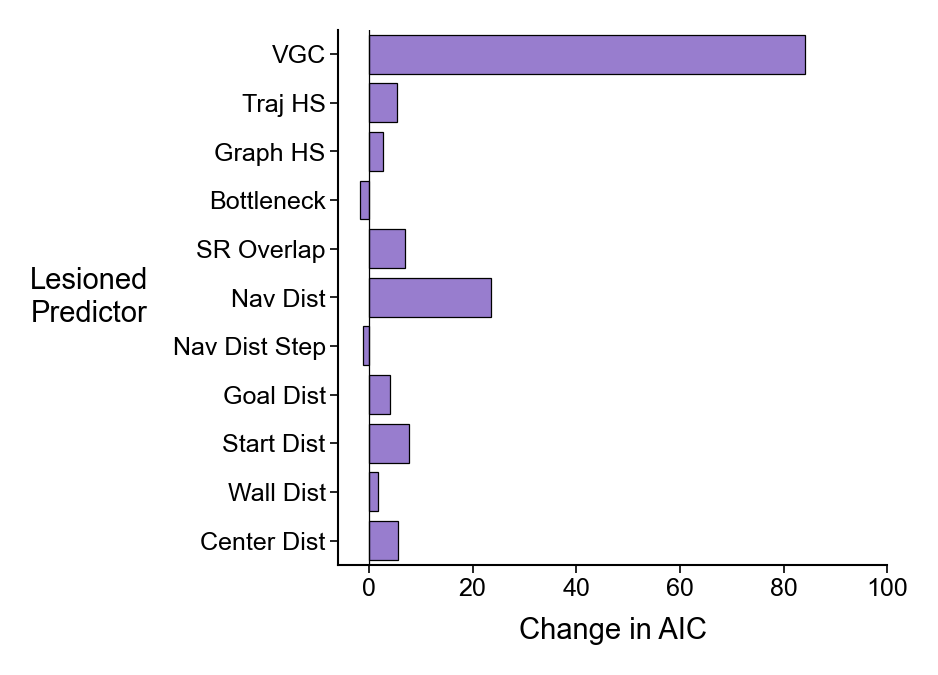

In [10]:
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 
spinewidth = .5

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
fig, ax = plt.subplots(
    1, 1, 
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
g = sns.barplot(
    data=exp3_lesion_correct_res[exp3_lesion_correct_res['lesioned_effect'] != 'FULL'],
    x='dAIC.FULL',
    y='lesioned_effect',
    palette=['mediumpurple'],
    ec='k',
    linewidth=.30,
    ax=ax
)

plt.plot((0, 0), (-1, 13), '-k', linewidth=.30)
g.set_ylim(10.5, -0.5)
for spine in ['top','bottom','left','right']:
    ax.spines[spine].set_linewidth(spinewidth)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis = 'both', which = 'major', labelsize = 5, width=.4, length=2, pad=1)
fontdict={'font': 'Arial', 'fontsize': 6}
g.set_yticklabels(
    [short_predictor_names[t.get_text().replace('_Z', '')] for t in g.get_yticklabels()], 
    fontdict=fontdict
)
g.set_xticks([0, 20, 40, 60, 80, 100])
# g.set_xticks([0, 10, 20, 30, 40, 50])
g.set_xticklabels(g.get_xticks(), fontdict={**fontdict, 'fontsize': 6})
g.set_ylabel(
    "Lesioned\nPredictor", rotation=0, labelpad=20, va='center',
    fontdict={**fontdict, 'fontsize': 7}
)
g.set_xlabel(
    "Change in AIC",
    fontdict={**fontdict, 'fontsize': 7}
)
# g.set_aspect(7)
# fig.savefig("./results/exp3_acc_lesion_plot.svg")
fig.savefig("./results/exp3_acc_lesion_plot.pdf")